<a href="https://colab.research.google.com/github/annvorosh/GB/blob/CV_Med/%D0%A3%D1%80%D0%BE%D0%BA_02_%D0%9A%D0%BE%D0%BC%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%B8%D0%B8_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация пневмоторакса

### Введение

Цель занятия - создание классификатора, способного идентифицировать признаки пневмоторакса на Rg-снимках.

Пневмоторакс - это скопление воздуха в плевральной полости, приводящее к коллапсу легкого. Пневмоторакс может возникать в результате травмы или в связи с заболеваниями органов грудной клетки, либо спонтанно. В некоторых случаях коллапс легкого может представлять угрозу для жизни. Пневмоторакс обычно диагностируется рентгенологом на рентгеновском снимке органов грудной клетки.

Более подробно можно почитать здесь:

https://www.labstori.ru/book/pnevmotoraks/
https://www.zdorovie-klinika.ru/health/zabolevaniya/bronkho-legochnye-zabolevaniya/pnevmotoraks/

Модель дигностики пневмоторакса была бы полезена во многих клинических ситуациях: для быстрой сортировки рентгенограмм и определения приоритета для интерпретации рентгенологом или для более уверенной диагностики для нерентгенологов.

Мы рассмотрим ряд этапов, необходимых для построения и исследования DL-классификатора:
- препроцессинг и подготовка Rg-снимков в формате DICOM.
- настройка модели в pytorch lightning
- решение проблемы дисбаланса классов
- измерение точности диагностики с помощью AUC (Area Under the Curve) и ROC (Receiver Operating Characteristic)
- интерпретируемость и визуализация с помощью CAM (Class Activation Map).

-------------------------------------------------------------

### Данные

__Доступны по ссылке:__
https://www.kaggle.com/seesee/siim-train-test
(использовались в Kaggle-соревновании "SIIM-ACR Pneumothorax Segmentation".
https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data).

__Датасет включает:__<br>
12047 - train images <br>
3205 - test images (не будет использоваться).

Данные представлены в формате __DICOM__.

__Задача:__<br>
а) предсказать наличие пневмоторакса на изображениях<br>
б) указать местоположение заболевания с помощью Class Activation Map (CAM).

----------------------------------------

### Preprocessing

Итак, давайте перейдем к техническим аспектам.<br>
Первое. Мы должы определиться с препроцессингом.

- __resizing (224х224)__ - исходный размер изображений 1024х1024. **TODO Зачем мы выполняем ресайзинг?**
- __стандартизация__ значений пикселей в интервале [0,1], используя масштабирование 1/255, иными словами мы умножаем значение каждого пикселя на эту константу. **TODO Зачем?**
- __разбиение датасета на train и validation__
- __сохранение предобработанных изображений__ в папках: 0 - нет пневмоторакса 1 - пневмоторакс. Будет две папки в директории train, и две в директории validation.
- вычисление среднего и стандартного отклонения для __нормализации__ - для изображений train


Для вычисления $\mu$ и $\sigma$ необходимо вычисление суммы и суммы квадратов пикселей всего датасета. Так как датасет довольно большой, может не хватить памяти, поэтому мы используем прием, который позволит нам вычислить необходимые значения.<br>
Сначала вычислим сумму пикселей $$\sum_{}^{}x$$, а также сумму квадратов пикселей $$\sum_{}^{}x^{2}$$

Запишем суммы в две переменные sums и sums_squared.<br>
Теперь можем вычислить среднее:
$$\mu = \frac{sums}{N}$$

и стандартное отклонение:
$$\sigma = \sqrt{\frac{sums \_squared}{N} - \mu ^{2}}$$

---------------------------------------------

Ресайзинг изображений с размера 1024x1024 до размера 224x224 является довольно распространенной практикой в задачах компьютерного зрения и глубокого обучения. Вот несколько основных причин, по которым ресайзинг может быть необходим:

- Оптимизация вычислительной эффективности:
  - Большие изображения требуют больших вычислительных ресурсов для их обработки нейронными сетями.
  - Уменьшение размера изображений до 224x224 пикселей позволяет значительно снизить потребление памяти и ускорить вычисления.

- Соответствие требованиям нейронных сетей:
  - Многие популярные архитектуры нейронных сетей для компьютерного зрения, такие как VGG, ResNet, Inception, ожидают входные изображения размером 224x224 пикселей.
  - Использование изображений стандартного размера помогает упростить реализацию и облегчает применение предварительно обученных моделей.

- Согласованность данных:
  - При обучении нейронных сетей важно, чтобы все входные изображения имели одинаковый размер.
  - Ресайзинг всех изображений до 224x224 пикселей обеспечивает согласованность данных, что облегчает процесс обучения.

- Улучшение обобщения:
  - Ресайзинг может помочь сети обобщать лучше, так как при этом теряется некоторая детализация, что заставляет модель учиться более абстрактным признакам.


------------------------------------------------------------------

Стандартизация значений пикселей в интервале [0, 1] путем умножения на 1/255 является распространенной практикой в задачах машинного обучения с изображениями. Вот основные причины, по которым это делается:

- Нормализация диапазона значений:
  - Многие алгоритмы машинного обучения, особенно нейронные сети, работают лучше, когда входные данные находятся в стандартизованном диапазоне, например, от 0 до 1.
  - Это помогает избежать проблем, связанных с большими абсолютными значениями пикселей, которые могут доминировать в ходе обучения.

- Ускорение сходимости:
  - Нормализация входных данных помогает ускорить процесс сходимости при обучении нейронных сетей.
  - Это связано с тем, что нормализованные данные облегчают настройку весов и улучшают стабильность обучения.

- Улучшение обобщения:
  - Стандартизация данных может помочь модели лучше обобщать, фокусируясь на относительных, а не абсолютных различиях между пикселями.
  - Это может сделать модель более устойчивой к вариациям яркости или контрастности изображений.

- Согласованность с предварительно обученными моделями:
  - Многие предварительно обученные модели, такие как VGG, ResNet и другие, ожидают, что входные изображения будут находиться в диапазоне [0, 1].
  - Приведение изображений к этому диапазону облегчает применение таких предварительно обученных моделей.


-------------------------------------------------------------

torchvision.DatasetFolder - это утилита в библиотеке PyTorch, которая предоставляет удобный способ загрузки и обработки наборов данных, состоящих из изображений, организованных в иерархическую структуру папок.

Основные особенности torchvision.DatasetFolder:

- Структура данных:
  - Ожидает, что набор данных будет организован в виде папок, где каждая папка соответствует одному классу.
  - Например, если у вас есть набор данных для классификации изображений котов и собак, вы можете иметь две папки: "cats" и "dogs".

- Автоматическая загрузка:
  - torchvision.DatasetFolder автоматически находит все изображения в каждой папке и связывает их с соответствующими метками классов.
  - Это избавляет вас от необходимости вручную составлять списки файлов и меток.

- Трансформации:
  - torchvision.DatasetFolder позволяет применять различные трансформации к загруженным изображениям, такие как ресайзинг, нормализация, случайные повороты и т.д.
  - Это облегчает предварительную обработку данных перед их использованием в модели машинного обучения.

- Интеграция с PyTorch:
  - Выходные данные torchvision.DatasetFolder совместимы с PyTorch, что делает их легко интегрируемыми в конвейер обучения моделей.


--------------------------------------------------------------

### Датасет

- Используем __torchvision.DatasetFolder__
- После загрузки изображений выполним __Z-normalization__ с помощью уже вычисленных $μ$ и $\sigma$
$$x_{norm} = \frac{x - \mu }{\sigma }$$

то есть мы вычитаем среднее из каждого значения пикселя и делим на стандартное отклонение.<br>

- __Аугментация__<br>
    - random rotations
    - random translations
    - random scales
    - random resized crop

--------------------------------------------------------------------

### Модель

- __Pytorch-lightning__ - высокоуровневый интерфейс для PyTorch
    - автоматически использует GPU
    - простой интерфейс логирования (протоколирования) и callback
    - полный доступ ко всем переменным и параметрам
    
- __Архитектура - ResNet18__ (Deep Residual Learning for Image Recognition He. et all, 2010)
    - изменим количество входных каналов с 3 до 1 (т.к. мы работаем с gray-scale изображениями)
    - изменим выходное разрешение с 1000 до 1 (т.к. мы классифицируем на 2 класса)

- __Функция потерь__
    - BinaryCrossEntropyWithLogitsLoss (torch.nn.BCEWithLogitsLoss) - объединяет Sigmoid layer и BCELoss

$$l_{n} = -w_{n}\left [ y_{n}\cdot log\:  \sigma (n_{x}) + (1 - y_{n})\cdot log\: (1-\sigma (x_{n}))\right ]$$
        
- __Оптимизация__
    - Adam optimizer (lr = 1e-4)
    
- 35 epochs

-------------------------------------------------------------------

ResNet18 - это одна из популярных архитектур сверточных нейронных сетей, представленная в 2015 году в статье "Deep Residual Learning for Image Recognition" авторами Kaiming He, Xiangyu Zhang, Shaoqing Ren и Jian Sun.

Основные преимущества и недостатки архитектуры ResNet18:

Плюсы:

- Глубокая архитектура:
  - ResNet18 состоит из 18 слоев, что позволяет ему эффективно извлекать низкоуровневые и высокоуровневые признаки из изображений.
  - Глубокие модели, как правило, показывают лучшую производительность на сложных задачах.

- Остаточные соединения (residual connections):
  - Остаточные соединения помогают решать проблему исчезающих/взрывающихся градиентов, которая часто возникает в очень глубоких сетях.
  - Остаточные блоки позволяют сети легче обучаться и достигать лучшей производительности.

- Эффективность и скорость:
  - ResNet18 является относительно компактной и эффективной моделью, что делает ее удобной для развертывания на мобильных и встраиваемых устройствах.
  - Модель может быстро обучаться и делать быстрые прогнозы, что важно для многих практических применений.

- Предварительная обученная модель:
  - Доступны предварительно обученные версии ResNet18, обученные на крупных наборах данных, таких как ImageNet.
  - Это позволяет использовать перенос обучения и быстро адаптировать модель к новым задачам.

Минусы:

- Ограниченная производительность:
  - Несмотря на свою глубину, ResNet18 может иметь ограниченную производительность по сравнению с более глубокими версиями ResNet, такими как ResNet50 или ResNet101, особенно на сложных задачах.

- Меньшая точность:
  - ResNet18 может показывать меньшую точность, чем более глубокие версии ResNet, в особо сложных задачах, где требуется более богатое представление признаков.

- Меньший размер карт признаков:
  - Из-за меньшего количества слоев ResNet18 генерирует карты признаков меньшего размера, что может быть недостаточно для некоторых задач, таких как детекция объектов.

- Меньшая пропускная способность:
  - Из-за меньшего количества параметров и вычислений ResNet18 может иметь меньшую пропускную способность по сравнению с более крупными версиями ResNet.


--------------------------------------------------

### Интерпретируемость

- Почему наша модель детектирует пневмоторакс на конкретном снимке?
Ответ на этот вопрос позволил бы расширить возможности применения нашей модели в популяции и среди специалистов. Это возможно сделать путем извлечения фрагментов изображения, имеющих наибольшее значение для предсказания. Иными словами:
- Какая часть изображения в наибольшей степени имеет значение для классификатора?

Одним из возможных вариантов решения этой задачи является использование __Class Activation Map (CAM)__ (Learning Deep Features for Discriminative Localization. Zhou et al., 2015)

CAM рассчитывается следующим образом:
- извлечь (сохранить) вывод А (признаки) с помощью k фильтров последнего сверточного слоя
- извлечь веса w полносвязного слоя - эти веса совместно с выводом последнего сверточного слоя используются для предсказания.
- вычислить скалярное произведение А и w (dot product) - это и есть CAM


$$M = \sum_{k}^{}w_{k}A_{k}$$

В питоне это выглядит так:
```python
cam = torch.zeros((features.width * features.height))
for i in range(len(cam)):
    cam[i] = torch.sum(weight * features[:,i])
```

Сначала мы создаем пустой массив cam, равный произведению ширины и высоты матрицы признаков (feature map).
Например, если последний слой представлен тензором размером 24x7x7, то cam состоит из 49 элементов.
Далее мы проходим по этим 49 элементам и вычисляем произведение между каждым элементом и  весами соответствующего индекса i. В нашем примере из 24 фильтров наш вектор будет состоять из 24 весов и 24 фичей в каждой из 49 позиций. Таким образом, это умножение состоит из 24 элементов, которые мы последовательно суммируем. Эти значение сохраняются под соответствующим индексом в массиве cam.

Однако, существуют некоторые ограничения к применению CAM:
- работает только с CNN
- требует специфической структуры: Convolution -> Global Average Pooling -> Fully Connected
- работает только в сетях с единственным FC layer

Если есть необходимость использовать CAM не с CNN, то существуют альтернативные варианты:
- GradCAM (Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
Selvaraju et al., 2016)
- GradCAM++(Grad-CAM++: Improved Visual Explanations for Deep Convolutional Networks
Chattopadhyay et al., 2017)
- ScoreCAM (Score-CAM: Score-Weighted Visual Explanations for Convolutional Neural Networks
 Wang et al., 2019)

Итак, мы закончили с обзором и можем приступить к практике.

------------------------------------------------------------------

###GradCAM:

Плюсы:

- Обеспечивает визуальное объяснение процесса принятия решений моделью, выделяя области входного изображения, наиболее важные для прогноза модели.
- Вычислительно эффективен, так как требует только одного обратного прохода через сеть.
- Может применяться к широкому кругу CNN-моделей, включая модели классификации, обнаружения и сегментации.
- Обеспечивает классово-дискриминативную карту локализации, которая выделяет релевантные области для конкретного прогноза класса.

Минусы:

- Карта локализации, создаваемая GradCAM, может быть грубой и не обеспечивать точной информации о точных границах релевантных областей.
- GradCAM чувствителен к выбору целевого слоя, и производительность может варьироваться в зависимости от выбранного слоя.
- GradCAM может работать не так хорошо на моделях со связями пропуска или со сложными архитектурами, так как градиенты могут становиться менее информативными.


------------------------------------------------------------

### GradCAM++:

Плюсы:

- Улучшает оригинальный GradCAM, введя взвешенную сумму положительных частных производных выхода модели по отношению к активациям карты признаков.
- Обеспечивает более точную и детальную карту локализации по сравнению с GradCAM, особенно для сценариев с несколькими объектами.
- Снижает чувствительность к выбору целевого слоя, делая его более устойчивым к различным архитектурам модели.
- Позволяет лучше визуализировать внимание модели к релевантным областям во входном изображении.

Минусы:

- Дополнительные вычисления, необходимые для взвешенной суммы частных производных, делают GradCAM++ немного более вычислительно сложным, чем оригинальный GradCAM.
- Улучшение точности локализации может быть незначительным для всех типов моделей и наборов данных.
- Выбор соответствующих гиперпараметров (например, показателя, используемого во взвешенной сумме) по-прежнему может влиять на качество объяснений.


--------------------------------------------------

### ScoreCAM:

Плюсы:

- Обеспечивает более интуитивное и интерпретируемое визуальное объяснение по сравнению с GradCAM и GradCAM++.
- Генерирует карту локализации, напрямую оценивая влияние каждого пространственного местоположения на прогноз модели, вместо того, чтобы полагаться на градиенты.
- Работает хорошо на широком спектре CNN-моделей, включая модели со сложными архитектурами.
- Производит более точные и детальные карты локализации, особенно для сценариев с несколькими объектами.
- Избегает потенциальных проблем нестабильности, связанных с методами, основанными на градиентах.

Минусы:

- Требует множества прямых проходов через сеть для вычисления влияния каждого пространственного местоположения, что может быть более вычислительно дорогостоящим, чем GradCAM и GradCAM++.
- Выбор соответствующих гиперпараметров (например, количества возмущений маски) по-прежнему может влиять на качество объяснений.
- Может не предоставлять столько же информации о внутреннем процессе принятия решений модели, как методы, основанные на градиентах, такие как GradCAM и GradCAM++.


--------------------------------------------------------------------

## Загрузка данных из Kaggle в Colab

Для скачивания датасета из Kaggle требуется наличие аккаунта и API-токена.
1. Для создания API-токена заходим в My Account, после чего — Create New API Token.
2. Открываем файл kaggle.json и копируем его содержимое в виде {"username":"########", "key":"################################"}.
3. Выполняем следующие команды в Colab:


In [1]:
! mkdir ~/.kaggle #создаем каталог .kaggle в корневой директории
! echo '{"username":"prubin","key":"bc63154694525c4eac572416b03d0f0a"}' > ~/.kaggle/kaggle.json #записываем учетные данные kaggle API в kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  # устанавливаем разрешения
! pip install kaggle #устанавливаем библиотеку kaggle

4. Скачиваем нужный датасет с помощью команды:

In [ ]:
# ! kaggle datasets download -d seesee/siim-train-test/SIIM_TRAIN_TEST -p /content/kaggle/

! kaggle datasets download -d anisayari/siimacrpneumothoraxsegmentationzip-dataset -p /content/kaggle/

Dataset URL: https://www.kaggle.com/datasets/anisayari/siimacrpneumothoraxsegmentationzip-dataset
License(s): unknown
 38% 5.60G/14.7G [05:17<06:59, 23.3MB/s]

## Загрузка данных с гугл-диска

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/kaggle/

!cp -R '/content/drive/MyDrive/GEEKBRAINS/02_Computer Vision для медицинских изображений/02 урок/archive.zip' '/content/kaggle/'

Распаковываем zip-архив

In [ ]:
import zipfile

#data_r = zipfile.ZipFile('/content/kaggle/siim-train-test.zip', 'r')
data_r = zipfile.ZipFile('/content/kaggle/archive.zip', 'r')
data_r.extractall('/content/kaggle/')

## Preprocessing

Импортируем и устанавливаем необходимые библиотеки.

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 33.3 MB/s 


In [ ]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm.notebook import tqdm

In [ ]:
labels = pd.read_csv('kaggle/siim/train-rle.csv')

In [ ]:
labels.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


Как видно, у нас два столбца, первый - уникальный ID пациента, второй - координаты расположения пневмоторакса.
Видно, что изображения с пневмотораксом закодированы (run-length-encoded (RLE) (Кодирование повторов), но в данном занятии нам это не потребуется, так как у нас стоит задача классификации, поэтому мы заменим метки на 0 и 1.

Изображения без пневмоторакса имеют код -1.<br>

Проверим количество кейсов. Имеется 12954 записи.


In [ ]:
print(f"Всего записей: {labels['ImageId'].count()}, из них уникальных {labels['ImageId'].value_counts().shape[0]}")

Всего записей: 12954, из них уникальных 12047


In [ ]:
labels = labels.drop_duplicates('ImageId')

После удаления дубликатов осталось 12047 записей.

In [ ]:
labels.shape

(12047, 2)

Теперь проверим инофрмацию по столбцам. Переименуем столбец с метками, назовем его 'Target', а также заменим значения координат на метки классов 0 - нет пневмоторакса и 1 - есть пневмоторакс.

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12047 entries, 0 to 12953
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ImageId         12047 non-null  object
 1    EncodedPixels  12047 non-null  object
dtypes: object(2)
memory usage: 282.4+ KB


In [ ]:
labels.columns = ['ImageId', 'Target']

In [ ]:
labels['Target'][labels['Target'].values != '-1'] = 1
labels['Target'][labels['Target'].values == '-1'] = 0
labels['Target']=labels.Target.astype('int64')

In [ ]:
labels.head()

,ImageId,Target
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,0
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,1
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,0
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,1
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,1


Создадим корневой путь к тренировочном dicom файлам, а также путь к обработанным файлам.

In [ ]:
ROOT_PATH = Path("kaggle/siim/dicom-images-train")
SAVE_PATH = Path("/content/Processed/train_or_val/")

Получим список файлов в директории с тренировочными файлами.

In [ ]:
all_train_dcm = list(ROOT_PATH.rglob("*/*/*.*"))
all_train_dcm[0]

PosixPath('kaggle/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1278.1517875167.92616/1.2.276.0.7230010.3.1.3.8323329.1278.1517875167.92615/1.2.276.0.7230010.3.1.4.8323329.1278.1517875167.92617.dcm')

Визуализируем некоторые изображения.
Для этого создадим subplot 3х3, чтобы вывести 9 изображений и соответствующие метки.<br>

Код создает сетку из 3 строк и 3 столбцов (9 subplot) для визуализации диагностических изображений DICOM (Digital Imaging and Communications in Medicine) и их соответствующих меток (таргетов).

- fig, axis = plt.subplots(3, 3, figsize=(12, 12)) создает фигуру (figure) с размерами 12x12 дюймов и массив subplot'ов (axis) размером 3x3.

Создается счетчик c для итерации по спискам изображений и меток.

Во вложенном цикле:
- dcm = pydicom.read_file(all_train_dcm[c]).pixel_array читает DICOM-файл из списка all_train_dcm и извлекает массив пикселей.
- label = labels['Target'].iloc[c] получает целевое значение (метку) из DataFrame labels для соответствующего изображения.
- axis[i][j].imshow(dcm, cmap='gray') отображает массив пикселей в subplot с использованием цветовой карты "gray".
- axis[i][j].set_title(label) устанавливает заголовок subplot'а равным метке.
- c += 1 увеличивает счетчик для следующей итерации.


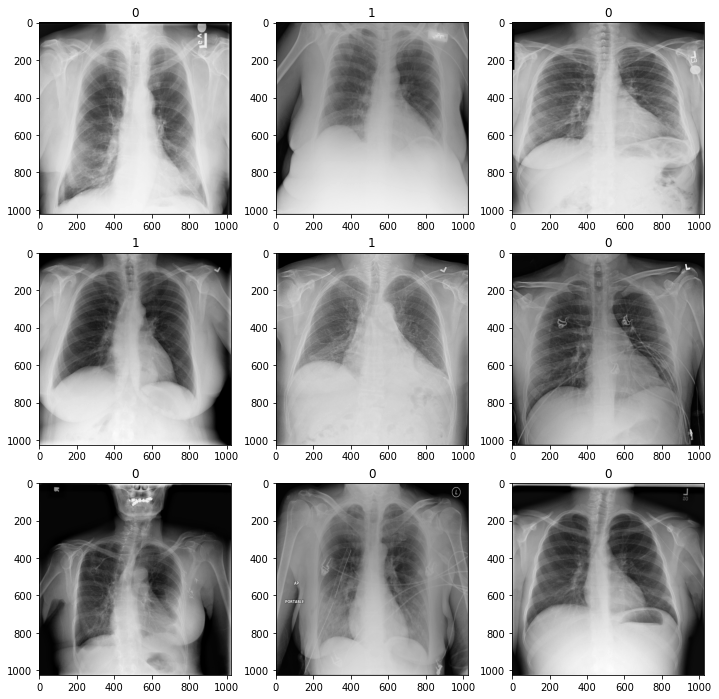

In [ ]:
# Для начала создадим объекты fig и axis и используем функцию plt.subplots,
# введем число строк и столбцов, а также зададим размер изображения  12x12
fig, axis = plt.subplots(3, 3, figsize=(12, 12))
# Создадим переменную - счетчик циклов с исходным значением 0
c = 0
# Создадим вложенный цикл: внешний - итерации по строкам, внутренний - по столбцам
for i in range(3):
    for j in range(3):
        # В функцию read_file передаем путь к файлу и получаем массив пикселей dicom файла
        dcm = pydicom.read_file(all_train_dcm[c]).pixel_array

        # Сохраним значение таргета в переменной label
        label = labels['Target'].iloc[c]

        # Воспользуемся функцией imshow для отображения массива пикселей.
        # Значение color map установим 'bone' или 'gray'
        axis[i][j].imshow(dcm, cmap='gray')

        # В качестве заголовка просто установим значение таргета
        axis[i][j].set_title(label)
        # Увеличим значение счетчика
        c+=1

Визуализация отдельного изображения и некоторые статистики пикселей.

Код визуализирует один из DICOM-снимков из набора данных all_train_dcm и выводит его характеристики.

- plt.figure(figsize=(12, 12)) создает фигуру (figure) размером 12x12 дюймов для визуализации изображения.

- raw_image = pydicom.read_file(all_train_dcm[1]).pixel_array читает DICOM-файл из списка all_train_dcm под индексом 1 и извлекает массив пикселей изображения.

- plt.imshow(raw_image, cmap='gray') отображает массив пикселей изображения с использованием цветовой карты "gray".

- plt.colorbar() добавляет цветовую шкалу (colorbar) к изображению.

- plt.title('Rg органов грудной клетки') устанавливает заголовок изображения.

- print(f"Разрешение изображения: ширина {raw_image.shape[0]} пикселей и высота {raw_image.shape[1]} пикселей, один канал") выводит информацию о размерах изображения (ширина, высота и количество каналов).

- print(f"Максимальное значение пикселя {raw_image.max():.1f} минимальное значение {raw_image.min():.1f}") выводит максимальное и минимальное значения пикселей в изображении.

- print(f"Среднее пикселей {raw_image.mean():.2f} стандартное отклонение {raw_image.std():.2f}") выводит среднее значение и стандартное отклонение пикселей в изображении.


Разрешение изображения: ширина 1024 пикселей и высота 1024 пикселей, один канал
Максимальное значение пикселя 250.0 минимальное значение 2.0
Среднее пикселей 151.92 стандартное отклонение 53.52


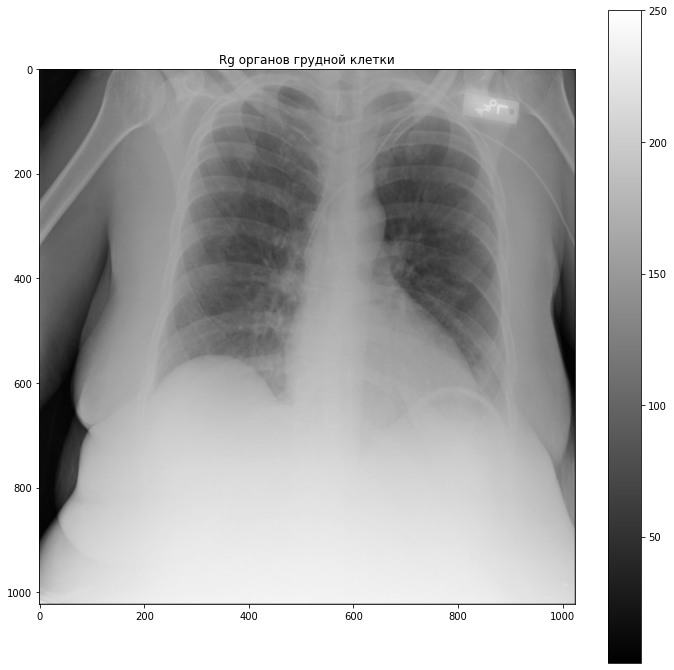

In [ ]:
plt.figure(figsize=(12, 12))
raw_image = pydicom.read_file(all_train_dcm[1]).pixel_array
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Rg органов грудной клетки')
print(f"Разрешение изображения: ширина {raw_image.shape[0]} пикселей и высота {raw_image.shape[1]} пикселей, один канал")
print(f"Максимальное значение пикселя {raw_image.max():.1f} минимальное значение {raw_image.min():.1f}")
print(f"Среднее пикселей {raw_image.mean():.2f} стандартное отклонение {raw_image.std():.2f}")

Посмотрим распределение значений пикселей отдельного изображения.

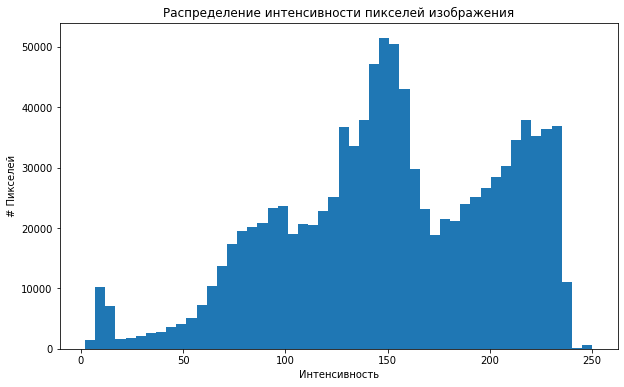

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(raw_image.ravel(), bins=50)
plt.title('Распределение интенсивности пикселей изображения')
plt.xlabel('Интенсивность')
plt.ylabel('# Пикселей')
plt.show()

## Подготовка датасета

Для того чтобы эффективно доставлять наши данные в DataLoader, конвертируем данные, хранящиеся в формате DICOM, в массив numpy. Затем выполним нормализацию, для этого мы вычислим среднее и стандартное отклонение значений пикселей всего датасета. После этого массивы numpy, содержащие значения нормализованных пикселей, мы сохраним в 2 раздельные папки:
- 0 - изображения без пневмоторакса
- 1 - изображения с пневмотораксом

Это нужно для использования  torchvision DatasetFolder для чтения файлов.<br>

Выполним стандартизацию всех изображений по максимальному значению пикселя - 255, а также ресайзинг до разрешения 224х224.<br>

In [ ]:
!mkdir /content/Processed/

In [ ]:
# Определим две переменные для хранения суммы и суммы квадратов
sums, sums_squared = 0, 0

# В цикле будем проходить по всем ID пациентов.
# tqdm используется для отображения прогресс бара
for c, image_id in enumerate(tqdm(labels.ImageId)):
    # Получаем полный путь к dicom файлу
    dcm_path = glob('kaggle/siim/dicom-images-train' + '/*/*/' + image_id + '.dcm')[0]

    # Чтение dicom файла и стандартизация массива
    dcm = pydicom.read_file(dcm_path).pixel_array / 255

    # Ресайзинг изображений до 224x224 и конвертация в тип float16
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

    # Получаем соответствующую метку таргета
    label = labels.Target.iloc[c]

    # Для определения принадлежности файла к тренировочному или валидационному
    # используем функцию enumerate и будем сохранять файлы в соответствующие директории
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 9600 else "val"

    # Путь для сохранения файлов. Обратите внимание, что путь должен быть типа string, поэтому srt(label)
    #current_save_path = SAVE_PATH/Processed/train_or_val/str(label)
    current_save_path = SAVE_PATH/str(label)
    # Создаем директории и устанавливаем аргумент parents=True, чтобы mkdir гарантированно создал все
    # родительские пути до файла, второй аргумент предотвращает ошибку функции, если путь уже существует
    current_save_path.mkdir(parents=True, exist_ok=True)
    # Сохранение массива в соответствующую директорию
    np.save(current_save_path/image_id, dcm_array)

    # Далее нам нужно обновить переменны sums и sums_squared

    # Определим количество пикселей в изображении, т.е. 244*244
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]

    # Используем только тренировочные данные для расчета статистик, это необходимо, чтобы валидационные
    # данные не имели влияния на тренировочные
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


  0%|          | 0/12047 [00:00<?, ?it/s]

- mean = sums / 9600 вычисляет среднее значение, разделяя сумму всех значений (sums) на количество элементов в наборе данных (в данном случае 9600).

- std = np.sqrt((sums_squared / 9600) - mean**2) вычисляет стандартное отклонение. Для этого:
        sums_squared - это сумма квадратов всех значений в наборе данных.
        sums_squared / 9600 - это средний квадрат значений.
        mean**2 - это квадрат среднего значения.
        Разница между средним квадратом и квадратом среднего дает дисперсию.
        Взятие квадратного корня из дисперсии дает стандартное отклонение.

- print(f"Среднее: {mean}, Ст. отклонение: {std}") выводит вычисленные значения среднего и стандартного отклонения.

In [ ]:
mean = sums / 9600
std = np.sqrt((sums_squared / 9600) - mean**2)
print(f"Среднее: {mean}, Ст. отклонение: {std}")

Среднее: 0.490608142671131, Ст. отклонение: 0.24914927371232903


In [ ]:
#!zip -r /content/Processed.zip /content/Processed

In [ ]:
# Загрузка данных с гугл-диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/Processed.zip' '/content/drive/MyDrive/GEEKBRAINS/02_Computer Vision для медицинских изображений/02 урок'

#!mkdir -p kaggle/siim
#!cp '/content/drive/MyDrive/Colab Notebooks/Processed.zip' '/content/kaggle/siim/'

In [ ]:
import zipfile

data_r = zipfile.ZipFile('/content/kaggle/siim/Processed.zip', 'r')
data_r.extractall('/content/kaggle/siim/')

Наконец, рассчитываем значения среднего и стандартного отклонения. Среднее рассчитывается путем деления sums на 9600 - количество изображений в тренировочном датасете.
$$\mu = \frac{sums}{N}$$

Страндартное отклонение.
$$\sigma = \sqrt{\frac{sums \_squared}{N} - \mu ^{2}}$$

In [ ]:
# TODO лучше оставить значения в рассчетных переменных, чтобы потом не забыть, не запутаться
mean = 0.4906081094547195
std = 0.2491494391093048

In [ ]:
#!pip install torchmetrics

In [ ]:
#!pip install pytorch_lightning

Импортируем дополнительные библиотеки.

- import torch - импортирует библиотеку PyTorch, которая предоставляет широкий спектр инструментов для построения и обучения моделей глубокого обучения.

- from torch import nn - импортирует модуль nn (нейронные сети) из PyTorch, который содержит различные слои и функции активации, необходимые для построения моделей.

- import torchvision - импортирует библиотеку TorchVision, которая предоставляет предобученные модели и наборы данных, используемые в компьютерном зрении.

- from torchvision import transforms - импортирует модуль transforms из TorchVision, который содержит различные преобразования, применяемые к данным для их подготовки к обучению.

- import torchmetrics - импортирует библиотеку TorchMetrics, которая содержит различные метрики оценки производительности моделей машинного обучения.

- import pytorch_lightning as pl - импортирует библиотеку PyTorch Lightning, которая предоставляет высокоуровневый интерфейс для построения и обучения моделей на основе PyTorch.

- from pytorch_lightning.callbacks import ModelCheckpoint - импортирует класс ModelCheckpoint из PyTorch Lightning, который используется для сохранения лучших моделей во время обучения.

- from pytorch_lightning.loggers import TensorBoardLogger - импортирует класс TensorBoardLogger из PyTorch Lightning, который используется для ведения журнала обучения модели и визуализации метрик в TensorBoard.


In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

Используем DatasetFolder из torchvision: он позволяет передать корневой каталог и вернуть объект набора данных с доступом ко всем файлам внутри каталога и именем каталога в качестве метки класса.<br>
Нам нужно только определить функцию загрузчика, load_file, которая определяет, как будут загружаться файлы. Это очень удобно, поскольку нам нужно только загрузить наши ранее сохраненные файлы numpy. Кроме того, нам нужно определить список расширений файлов (в нашем случае "npy").

Наконец, мы можем передать последовательность преобразований для аугментации и нормализации данных.

Используем:

- RandomResizedCrops, которая применяет случайную обрезку изображения и изменяет его размер до размера исходного изображения (224x224).
- Случайные повороты от -5 до 5 градусов
- Случайное смещение (не более 5%)
- Случайное масштабирование (0,9-1,1 от исходного размера изображения)

In [ ]:
# Определим функцию, принимающую в качестве аргумента путь к numpy файлу
# и конвертирующую значения в тип данных float
def load_file(path):
    return np.load(path).astype(np.float32)

Далее выполним трансформации тренировочных и валидационных данных. transforms.Compose - принимает список различных преобразований и последовательно их выполняет.

In [ ]:
train_transforms = transforms.Compose([
                                    # конвертирует numpy array в тензор
                                    transforms.ToTensor(),
                                    # принимает в качестве аргументов наши, уже вычисленные mean and std
                                    transforms.Normalize(mean, std),
                                    # Аугментация данных. Рандомное афинное преобразование изображений.
                                    transforms.RandomAffine(
                                        # поворот на +-5 градусов
                                        degrees=(-5, 5),
                                        # трансляция на максимум 5%
                                        translate=(0, 0.05),
                                        # масштабирование
                                        scale=(0.9, 1.1)),
                                    # обрезает рандомные части изображения и затем выполняет ресайз до требуемого разрешения
                                    # важно, чтобы не обрезались части изображения, содержащие пневмоторакс
                                    # аргумент scale содержит кортеж, определяющий нижнюю и верхнюю границы кадрирования.
                                    transforms.RandomResizedCrop((224, 224), scale=(0.15, 1))

])

# для валидационный выборки нам не требуются все трансформации, поэтому оставляем только конвертацию в тензор и нормализацию
val_transforms = transforms.Compose([
                                    # конвертирует numpy array в тензор
                                    transforms.ToTensor(),
                                    # принимает в качестве аргументов наши, уже вычисленные mean and std
                                    transforms.Normalize(mean, std)
])




Наконец, мы создаем датасеты train и val и соответствующие загрузчики данных.

Здесь следует менять batch size и num_workers в соответствии с аппаратными ресурсами.

- train_dataset = torchvision.datasets.DatasetFolder(...):
  - 'Processed/train' - путь к директории, содержащей данные для обучения.
  - loader=load_file - функция, которая используется для загрузки файлов. В данном случае, load_file - это пользовательская функция, которая должна быть определена отдельно.
  - extensions="npy" - расширение файлов, которые будут загружаться (в данном случае - numpy массивы).
  - transform=train_transforms - набор преобразований, которые будут применяться к каждому образцу данных во время обучения. Эти преобразования определяются в переменной train_transforms.

- val_dataset = torchvision.datasets.DatasetFolder(...):
  - 'Processed/val' - путь к директории, содержащей данные для валидации.
  - loader=load_file - та же функция загрузки файлов, что и для обучающего набора.
  - extensions='npy' - расширение файлов для валидационного набора.
  - transform=val_transforms - набор преобразований, применяемых к данным валидационного набора. Эти преобразования определяются в переменной val_transforms.


In [ ]:
train_dataset = torchvision.datasets.DatasetFolder(
    'Processed/train',
    loader=load_file,
    extensions="npy",
    transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    'Processed/val',
    loader=load_file,
    extensions='npy',
    transform=val_transforms)


Посмотрим на некоторые преобразованные изображения.

Этот код создает 2x2 сетку изображений, где каждое изображение представляет собой случайный образец из обучающего набора данных train_dataset.

    fig, axis = plt.subplots(2, 2, figsize=(12, 12)):
        Создает фигуру и сетку из 2x2 осей для визуализации изображений.
        figsize=(12, 12) задает размер фигуры как 12x12 дюймов.

    for i in range(2): и for j in range(2)::
        Это вложенные циклы, которые итерируются по осям 2x2 сетки.

    random_index = np.random.randint(0, 9600):
        Выбирает случайный индекс из диапазона от 0 до 9599 (предполагается, что размер обучающего набора данных составляет 9600 образцов).

    x_ray, label = train_dataset[random_index]:
        Извлекает случайный образец x_ray и его соответствующую метку label из обучающего набора данных train_dataset.

    axis[i][j].imshow(x_ray[0], cmap="gray"):
        Отображает извлеченный образец x_ray на соответствующей оси axis[i][j].
        x_ray[0] используется, потому что класс DatasetFolder автоматически добавляет количество каналов к извлеченным образцам.
        cmap="gray" указывает, что изображение должно быть отображено в оттенках серого.

    axis[i][j].set_title(f"Label:{label}"):
        Устанавливает заголовок для каждого изображения, указывающий соответствующую метку label.

Таким образом, этот код визуализирует 4 случайных образца из обучающего набора данных train_dataset в виде 2x2 сетки изображений, отображая каждый образец и его соответствующую метку.

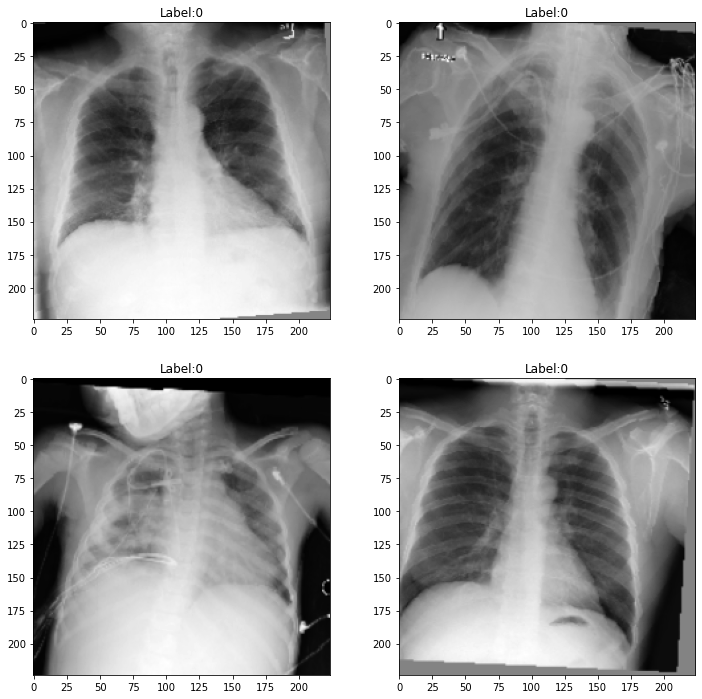

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(12, 12))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 9600)
        x_ray, label = train_dataset[random_index]
        # Класс DatasetFolder автоматически добавляет количество каналов, поэтому используем индекс x_ray[0]
        axis[i][j].imshow(x_ray[0], cmap="gray")
        axis[i][j].set_title(f"Label:{label}")

Разрешение изображения: ширина 224 пикселей и высота 224 пикселей, один канал
Максимальное значение пикселя 1.9 минимальное значение -1.8
Среднее пикселей 0.78 стандартное отклонение 0.81


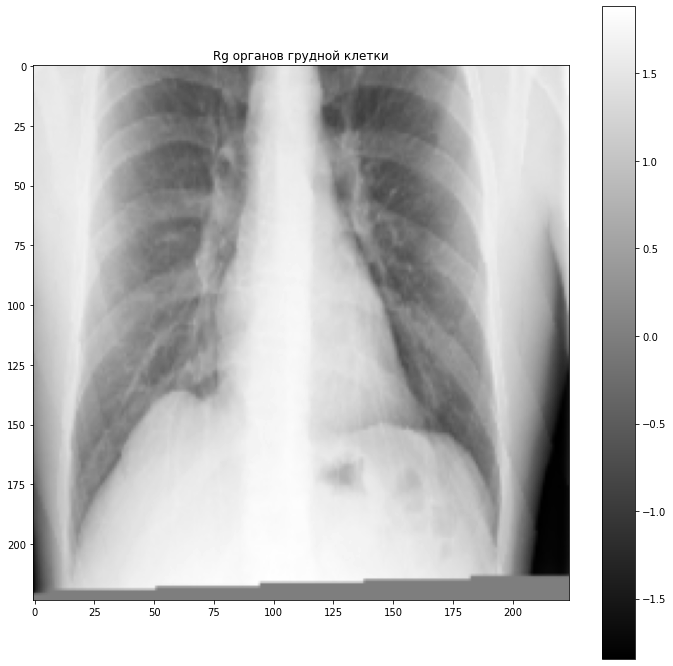

In [ ]:
plt.figure(figsize=(12, 12))
sample_image, l = train_dataset[0]
plt.imshow(sample_image[0], cmap='gray')
plt.colorbar()
plt.title('Rg органов грудной клетки')
print(f"Разрешение изображения: ширина {sample_image.shape[1]} пикселей и высота {sample_image.shape[2]} пикселей, один канал")
print(f"Максимальное значение пикселя {sample_image.max():.1f} минимальное значение {sample_image.min():.1f}")
print(f"Среднее пикселей {sample_image.mean():.2f} стандартное отклонение {sample_image.std():.2f}")

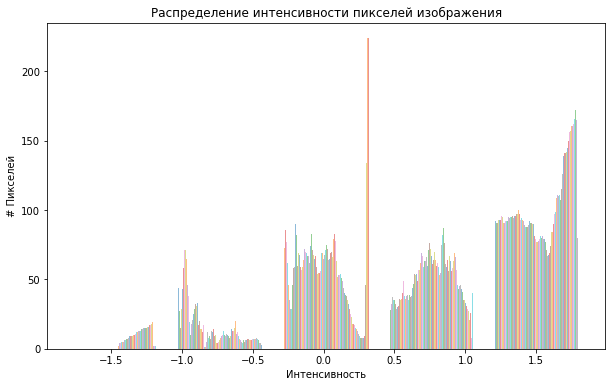

In [ ]:
plt.figure(figsize=(10,6))
#plt.hist(raw_image.ravel(), bins=50, alpha=0.5)
plt.hist(sample_image[0], bins=5, alpha=0.5)
plt.title('Распределение интенсивности пикселей изображения')
plt.xlabel('Интенсивность')
plt.ylabel('# Пикселей')
plt.show()

Далее создадим загрузчики данных для тренировочного и валидационного наборов данных.

In [ ]:
batch_size = 32
num_workers = 12

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False)

print(f"Всего {len(train_dataset)} тренировочных изображений и {len(val_dataset)} валидационных.")

Всего 9600 тренировочных изображений и 2447 валидационных.


Классы не сбалансированы: изображений без признаков пневмоторакса больше, чем с пневмотораксом. Существует несколько способов работы с несбалансированными наборами данных:

- Weighted Loss
- Resampling
- Ничего не делать

Используем WeightedLoss.

Объяснение WeightedLoss.

Создадим гепотетический набор true labels и набор predictions.

In [ ]:
y_true = np.array(
[[1],
[1],
[1],
[0]])
print(f"y_true: \n{y_true}")

y_true: 
[[1]
 [1]
 [1]
 [0]]


Чтобы лучше понять weighted loss, представьте, что у вас есть две модели. - Модель 1 всегда предсказывает 0,9 для любого примера, который ей дан. - Модель 2 всегда предсказывает 0,1.

In [ ]:
np.ones(4)

array([1., 1., 1., 1.])

In [ ]:
y_pred_1 = 0.9 * np.ones(y_true.shape)
print(f"y_pred_1: \n{y_pred_1}")
print()
y_pred_2 = 0.1 * np.ones(y_true.shape)
print(f"y_pred_2: \n{y_pred_2}")

y_pred_1: 
[[0.9]
 [0.9]
 [0.9]
 [0.9]]

y_pred_2: 
[[0.1]
 [0.1]
 [0.1]
 [0.1]]


При обычной функции потерь (не взвешенной) модель, которая всегда выдает 0,9, имеет меньшие потери (работает лучше), чем модель 2. Это происходит потому, что существует дисбаланс классов, когда 3 из 4 меток равны 1. Если бы данные были идеально сбалансированы (две метки были 1, а две - 0), то модель 1 и модель 2 имели бы одинаковые потери. Каждая из них получила бы два правильных и два неправильных примера. Однако, поскольку данные не сбалансированы, обычная функция потерь подразумевает, что модель 1 лучше, чем модель 2.

---------------------------------------------------------

Код вычисляет величину ошибки (loss) для модели с предсказаниями y_pred_1, используя истинные метки y_true. Это реализует так называемую "регуляризованную перекрестную энтропию" (regularized cross-entropy) или "бинарную перекрестную энтропию" (binary cross-entropy).

    loss_reg_1 = -1 * np.sum(y_true * np.log(y_pred_1)) -1 * np.sum((1 - y_true) * np.log(1 - y_pred_1)):
        Это формула для вычисления бинарной перекрестной энтропии (BCE) loss.
        y_true - это вектор истинных меток (0 или 1) для образцов.
        y_pred_1 - это вектор предсказанных вероятностей для каждого образца.
        Первое слагаемое -1 * np.sum(y_true * np.log(y_pred_1)) вычисляет потерю для положительных примеров (где y_true = 1).
        Второе слагаемое -1 * np.sum((1 - y_true) * np.log(1 - y_pred_1)) вычисляет потерю для отрицательных примеров (где y_true = 0).
        Оба слагаемых суммируются, чтобы получить общую величину ошибки.

    print(f"loss_reg_1: {loss_reg_1:.4f}"):
        Выводит значение ошибки loss_reg_1 с округлением до 4 знаков после запятой.

Бинарная перекрестная энтропия - это широко используемая функция потерь для задач бинарной классификации, где необходимо предсказать, принадлежит ли образец к одному из двух классов (0 или 1). Она стимулирует модель давать точные вероятностные предсказания для каждого класса.

In [ ]:
loss_reg_1 = -1 * np.sum(y_true * np.log(y_pred_1)) -1 * np.sum((1 - y_true) * np.log(1 - y_pred_1))
print(f"loss_reg_1: {loss_reg_1:.4f}")

loss_reg_1: 2.6187


Код вычисляет еще одну величину ошибки (loss), но на этот раз для модели с предсказаниями y_pred_2, используя те же истинные метки y_true. Это также реализует "регуляризованную перекрестную энтропию" (regularized cross-entropy) или "бинарную перекрестную энтропию" (binary cross-entropy).

    loss_reg_2 = -1 * np.sum(y_true * np.log(y_pred_2)) -1 * np.sum((1 - y_true) * np.log(1 - y_pred_2)):
        Это та же формула, что и для loss_reg_1, но с использованием другого вектора предсказаний y_pred_2 вместо y_pred_1.
        y_true - это вектор истинных меток (0 или 1) для образцов.
        y_pred_2 - это вектор предсказанных вероятностей для каждого образца, полученный от другой модели.
        Первое слагаемое -1 * np.sum(y_true * np.log(y_pred_2)) вычисляет потерю для положительных примеров (где y_true = 1).
        Второе слагаемое -1 * np.sum((1 - y_true) * np.log(1 - y_pred_2)) вычисляет потерю для отрицательных примеров (где y_true = 0).
        Оба слагаемых суммируются, чтобы получить общую величину ошибки.

    print(f"loss_reg_2: {loss_reg_2:.4f}"):
        Выводит значение ошибки loss_reg_2 с округлением до 4 знаков после запятой.

Таким образом, этот код вычисляет бинарную перекрестную энтропию (BCE) loss для другой модели, предсказывающей вероятности принадлежности к двум классам. Сравнение значений loss_reg_1 и loss_reg_2 может помочь оценить и сравнить качество предсказаний двух разных моделей.

In [ ]:
loss_reg_2 = -1 * np.sum(y_true * np.log(y_pred_2)) -1 * np.sum((1 - y_true) * np.log(1 - y_pred_2))
print(f"loss_reg_2: {loss_reg_2:.4f}")

loss_reg_2: 7.0131


Обратите внимание, что функция потерь дает больший loss, когда прогнозы всегда равны 0,1, потому что данные несбалансированы и имеют три метки 1 и только одну метку 0. Учитывая дисбаланс классов с большим количеством положительных меток, обычная функция потерь подразумевает, что модель с более высоким прогнозом 0,9 работает лучше, чем модель с более низким прогнозом 0,1.

При использовании взвешенной функции потерь вы получите одинаковый взвешенный loss, когда все предсказания равны 0,9 и когда все предсказания равны 0,1. Обратите внимание, что предсказание 0,9 находится на расстоянии 0,1 от положительной метки 1. - Также обратите внимание, что предсказание 0,1 находится на расстоянии 0,1 от отрицательной метки 0. Таким образом, модели 1 и 2 "симметричны" вдоль средней точки 0,5, если построить их на числовой прямой между 0 и 1.

Поскольку этот набор данных достаточно мал, вы можете рассчитать положительный вес, который будет использоваться во взвешенной функции потерь. Чтобы получить положительный вес, подсчитайте, сколько присутствует НЕГАТИВНЫХ меток, разделив их на общее количество примеров. В данном случае имеется одна отрицательная метка и четыре примера. Аналогично, отрицательный вес - это доля положительных меток.

In [ ]:
w_p = 1/4
w_n = 3/4
print(w_p)
print(w_n)

0.25
0.75


Weighted loss - модель 1.

Код представляет собой вычисление одного из компонентов общей функции потерь (loss function) в контексте машинного обучения.

Давайте разберем его по шагам:

    loss_1_pos = -1 * np.sum(w_p * y_true * np.log(y_pred_1 ))
        Эта строка вычисляет значение для одного из слагаемых функции потерь.
        w_p - это вектор весовых коэффициентов, который может использоваться для придания различного веса разным образцам.
        y_true - это вектор истинных значений (ground truth) для данных.
        y_pred_1 - это вектор прогнозируемых значений для первого класса.
        Берется поэлементное произведение w_p, y_true и логарифма y_pred_1, а затем суммируется по всем элементам. Результат умножается на -1, чтобы получить положительное значение потерь.

    print(f"loss_1_pos: {loss_1_pos:.4f}")
        Эта строка выводит значение loss_1_pos с точностью до 4 знаков после запятой.

In [ ]:
loss_1_pos = -1 * np.sum(w_p * y_true * np.log(y_pred_1 ))
print(f"loss_1_pos: {loss_1_pos:.4f}")

loss_1_pos: 0.0790


In [ ]:
loss_1_neg = -1 * np.sum(w_n * (1 - y_true) * np.log(1 - y_pred_1 ))
print(f"loss_1_neg: {loss_1_neg:.4f}")

loss_1_neg: 1.7269


In [ ]:
# Total loss
loss_1 = loss_1_pos + loss_1_neg
print(f"loss_1: {loss_1:.4f}")

loss_1: 1.8060


Weighted loss - модель 2.

In [ ]:
loss_2_pos = -1 * np.sum(w_p * y_true * np.log(y_pred_2))
print(f"loss_2_pos: {loss_2_pos:.4f}")

loss_2_pos: 1.7269


In [ ]:
loss_2_neg = -1 * np.sum(w_n * (1 - y_true) * np.log(1 - y_pred_2))
print(f"loss_2_neg: {loss_2_neg:.4f}")

loss_2_neg: 0.0790


In [ ]:
loss_2 = loss_2_pos + loss_2_neg
print(f"loss_2: {loss_2:.4f}")

loss_2: 1.8060


In [ ]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([7409, 2191])), (array([0, 1]), array([1969,  478])))

In [ ]:
print(7409/9600)
print(7409/2191)

0.7717708333333333
3.381560931081698


## Создание модели в pytorch lightning

Каждая модель pytorch lightning определяется, по крайней мере, методом **инициализации**, функцией **forward**, определяющей проход/прогнозирование вперед, функцией **training_step**, определяющей потери, и **configure_optimizers** - алгоритмом оптимизации.

Кроме того, мы можем использовать колбэк **training_epoch_end** для вычисления статистик датасета и метрик, таких как accuracy.

Затем мы определяем этап проверки (**validation_step**). Этап валидации выполняет примерно те же действия, что и этап обучения. В этом случае pytorch lightning не обновляет веса. Опять же, мы можем использовать **validation_epoch_end** для вычисления статистик датасета.

Кроме того, pl (pytorch lightning) управляет устройствами. Просто укажите количество GPU при создании модели.

Теперь пришло время создать модель - мы будем использовать сетевую архитектуру ResNet18.

Как и большинство моделей torchvision, оригинальная ResNet ожидает трехканальный ввод в conv1.
Однако наши Rg-данные имеют только один канал. Поэтому нам нужно изменить параметр in_channel с 3 на 1.

Кроме того, мы изменим последний FC слой, чтобы он имел только один вывод, поскольку у нас бинарная метка класса.

**Оптимизатор и функция потерь**

Мы используем оптимизатор Adam с коэффициентом обучения 0.0001 и функцию потерь BinaryCrossEntropy.

(На самом деле мы используем BCEWithLogitsLoss, которая принимает необработанные предсказанные значения и вычисляет сигмоидальную функцию активации перед применением кросс-энтропии). Не стесняйтесь передавать вес, отличный от 1, в модель пневмонии, чтобы использовать взвешенную функцию потерь.

-------------------------------------------

PyTorch Lightning - это высокоуровневая библиотека для машинного обучения, построенная поверх основной библиотеки PyTorch. Она предлагает множество преимуществ, но также имеет некоторые ограничения. Давайте рассмотрим основные плюсы и минусы использования PyTorch Lightning:

Плюсы:

- Модульность и абстракция: PyTorch Lightning предлагает высокоуровневую модульную структуру, которая отделяет логику модели, данных и тренировки. Это облегчает разработку и поддержку сложных моделей.

- Автоматизация рутинных задач: Lightning автоматизирует множество рутинных задач, таких как управление тренировкой, параллельное вычисление, логирование, проверка на валидационном множестве и т.д. Это позволяет сфокусироваться на разработке и обучении модели.

- Масштабируемость и распределенные вычисления: Lightning поддерживает распределенное обучение на нескольких GPU, что значительно ускоряет тренировку моделей.

- Упрощение кода: Благодаря высокоуровневой абстракции, код в Lightning становится более читабельным и компактным по сравнению с "чистым" PyTorch.

- Интеграция с экосистемой: Lightning плотно интегрируется с другими популярными библиотеками и инструментами, такими как Weights & Biases, TensorBoard, Hydra и др.

Минусы:

- Ограничения гибкости: Хотя Lightning предлагает много удобных функций, это может приводить к ограничениям гибкости по сравнению с "чистым" PyTorch, особенно для очень специфических или нестандартных задач.

- Кривая обучения: Для эффективного использования Lightning требуется понимание его философии и архитектуры, что может занять некоторое время для новичков в машинном обучении.

- Зависимость от PyTorch: Lightning полностью построен поверх PyTorch, поэтому разработчикам, не знакомым с PyTorch, может быть сложнее начать работу с Lightning.

- Производительность: В некоторых сценариях ручная настройка PyTorch может дать небольшое преимущество в производительности по сравнению с использованием Lightning.


---------------------------------------------------

- (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False): Это первый сверточный слой в сети. Он принимает на вход изображение с 3 каналами (то есть RGB-изображение) и выдает 64 карты признаков.Размер ядра сверки - 7x7, шаг - 2x2, а размер padding - 3x3. bias=False означает, что в этом слое нет обучаемых смещений.

- (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True): Это слой пакетной нормализации, который следует за первым сверточным слоем. Он нормализует 64 карты признаков, вычитая среднее значение и деля на стандартное отклонение для каждой карты. Параметр eps - это небольшое значение, добавляемое к стандартному отклонению, чтобы избежать деления на ноль. Параметр momentum контролирует экспоненциальное скользящее среднее, используемое для вычисления текущих среднего и отклонения. Параметр affine указывает, что слой имеет обучаемые аффинные параметры (масштаб и смещение). Параметр track_running_stats указывает, должен ли слой отслеживать текущие среднее и отклонение во время обучения.

- (relu): ReLU(inplace=True): Это функция активации ReLU (Rectified Linear Unit). Она применяет нелинейное преобразование f(x) = max(0, x) к картам признаков. Параметр inplace=True означает, что преобразование выполняется на месте, экономя память.

- (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False): Это слой максимального pooling. Он уменьшает размерность карт признаков, выбирая максимальное значение в окне 3x3 с шагом 2 и padding 1. Параметр dilation равен 1, что означает, что сжатие не применяется. Параметр ceil_mode равен False, что означает, что размер выходного сигнала вычисляется с использованием floor, а не ceil.

- (layer1): Sequential(...): Это первый слой блока остаточной связи (ResNet-блок). Он состоит из двух экземпляров BasicBlock, каждый из которых содержит два сверточных слоя, пакетную нормализацию и функцию активации ReLU. BasicBlock является основным строительным блоком архитектуры ResNet, который помогает обучать очень глубокие нейронные сети.

В целом, этот фрагмент кода представляет начальные слои модели в стиле ResNet, включая первый сверточный слой, пакетную нормализацию, активацию ReLU, максимальный pooling и первый остаточный блок.

In [ ]:
# Посмотрим архитектуру модели
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Обычно, когда вы работаете с pytorch, вы наследуете из класса pytorch.module
# При работе с pl, вы наследуете из класса pl.LightningModule
class PneumothoraxModel(pl.LightningModule):
    # Сначала определим метод init, как обычно в питоне
    # В функции init вы создаете или загружаете модуль, определяющий оптимизатор и функцию потерь,
    # а также метрику.
    def __init__(self, weight=3):

        super().__init__()
        # Как уже упоминалось, мы будем использовать ResNet. Присвоим переменной self.model
        # К счастью на не нужно создавать модель с нуля, мы можем просто загрузить ее
        self.model = torchvision.models.resnet18()

        # Для того, чтобы поменять количество входных каналов с 3 до 1, нам нужен доступ
        # к определенному слою. Нам нужно заменить в первом слое число входных каналов с 3 на 1
        # (см. структуру модели выше)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # аналогично меняем в FC слое out_features с 1000 на 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        # Создадим оптимизатор
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)  # TODO такие параметры как lr лучше передавать в класс как параметр (например, через конфиг)
        # Для использования взвешенной версии этой функции, мы должны передать аргумент
        # pos_weight, где определим вес, который он должен использовать. pos_weight принимает
        # тензор, а не скаляр, поэтому мы конвертируем вес 3 в torch.tensor
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # Определим метрики  # TODO кстати, не обязательно создавать два экземпляра класса Accuracy, тк она не использует "историю" предсказаний как например mAP
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

        # Функция выполняет прямое распространение. В нашем случае получаем output ResNet18,
        # и возвращаем предсказание
    def forward(self, data):
        pred = self.model(data)
        return pred

        # Функция выполняется автоматически pl
    def training_step(self, batch, batch_idx):
        # получаем изображение и метку из текущего батча
        x_ray, label = batch
        # конвертируем метку во флоат, т.к. pytorch не вычисляет лосс с integer
        label = label.float()
        # Для вычисления pred используется функция forward, в pl не нужно вызывать
        # self.forward, можно просто вызвать self с изображением
        # Убедитесь, что label и pred имеют одинаковую размерность:
        # pred имеет размерность [batch_size,1], поэтому нам нужно удалить второе измерение
        pred = self(x_ray)[:,0]
        # Вычисляем loss
        loss = self.loss_fn(pred, label)

        # Можно записывать лог функции потерь батча и  accuracy
        self.log('Train Loss', loss)
        # torchmetrics ожидает порог 0.5, а в текущий момент у нас порог = 0
        # чтобы конвертировать наш pred в вероятность используем функцию sigmoid, теперь порог = 0.5
        # также функция accuracy ожидает label типа int
        self.log('Step Train Acc', self.train_acc(torch.sigmoid(pred), label.int()))

        return loss

        # outs (outputs) содержит все элементы одного шага, то есть все loss
        # Функция определяет что происходит, после одной эпохи. Мы получаем accuracy
        # всего training сета
#         TODO кстати, логгировать метрики можно и в обычных функицях _step. Для этого у метода .log() есть параметры on_step и on_epoch
    def training_epoch_end(self, outs):
        self.log("Train Acc", self.train_acc.compute())

'''
    def validation_step(self, batch, batch_idx)::
        Это метод, который вызывается во время валидации модели на каждом батче данных.
        batch содержит входные данные (x_ray) и соответствующие им метки (label).
        batch_idx - это индекс текущего батча в наборе валидационных данных.

    x_ray, label = batch:
        Извлекаем входные данные (x_ray) и метки (label) из пакета данных.

    label = label.float():
        Приводим метки к формату с плавающей точкой, так как иногда метки могут быть целочисленными.

    pred = self(x_ray)[:,0]:
        Передаем входные данные x_ray через модель (self) для получения прогнозов.
        [:,0] означает, что мы берем первый (и единственный) элемент выходного вектора предсказаний, так как в данном случае, вероятно, речь идет о бинарной классификации.

    loss = self.loss_fn(pred, label):
        Вычисляем значение функции потерь, сравнивая прогнозы (pred) с истинными метками (label).
        self.loss_fn - это определенная пользователем функция потерь, используемая для обучения модели.

    self.log("Val Loss", loss):
        Логируем значение потерь на валидационном наборе, чтобы отслеживать его в ходе обучения.

    self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int())):
        Вычисляем и логируем значение метрики точности на текущем батче.
        torch.sigmoid(pred) применяет сигмоидную функцию к прогнозам, чтобы получить вероятности принадлежности к классам.
        label.int() приводит метки к целочисленному формату, необходимому для вычисления точности.
        self.val_acc - это определенная пользователем метрика точности, используемая для оценки производительности модели.

    def validation_epoch_end(self, outs):
        Этот метод вызывается в конце каждой эпохи валидации.
        Здесь мы логируем общую метрику точности на валидационном наборе за всю эпоху, используя self.val_acc.compute().

    def configure_optimizers(self):
        Этот метод возвращает список оптимизаторов, которые будут использоваться для обучения модели.
        В данном случае, он возвращает единственный оптимизатор, self.optimizer.
'''
    def validation_step(self, batch, batch_idx):
        # Те же шаги, что и в training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0] # TODO что тут происходит?

        loss = self.loss_fn(pred, label)

        self.log("Val Loss", loss)
#         TODO можно еще напомнить народу, что sigmoid - только для бинарной классификации
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss

    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())

        # Возвращает список оптимизаторов.
    def configure_optimizers(self):
        return [self.optimizer]



In [ ]:
# создаем экземпляр модели
model = PneumothoraxModel()

- checkpoint_callback = ModelCheckpoint(...): ModelCheckpoint - это специальный обратный вызов (callback) в библиотеке PyTorch Lightning, который отслеживает определенные метрики во время обучения и сохраняет лучшие модели.

- monitor='Val Acc': Этот параметр указывает, какую метрику мы хотим отслеживать для определения лучших моделей. В данном случае, мы будем отслеживать метрику "Val Acc" (точность на валидационном наборе).

-save_top_k=10: Этот параметр определяет, сколько лучших моделей мы хотим сохранить. Здесь мы сохраняем 10 лучших моделей по метрике "Val Acc".

- mode='max': Этот параметр определяет, что мы хотим максимизировать метрику "Val Acc" для определения лучших моделей. Другие возможные значения: 'min' (минимизация метрики) и 'auto' (автоматическое определение, в зависимости от метрики).

Таким образом, этот код создает объект ModelCheckpoint, который будет отслеживать метрику "Val Acc" во время обучения и сохранять 10 лучших моделей, основываясь на максимальном значении этой метрики.

In [ ]:
# создаем чекпоинт, основанный на валидационной accuracy
# автоматически сохраняет чекпоинты в течение тренинга
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

Код создает объект Trainer в библиотеке PyTorch Lightning, который используется для обучения модели. Давайте разберем эту часть кода подробно:

- gpus = 1: Этот параметр указывает, что мы хотим использовать 1 GPU для обучения модели.

- trainer = pl.Trainer(...): pl.Trainer - это основной класс в PyTorch Lightning, который отвечает за управление обучением модели. Этот объект объединяет в себе всю логику обучения, валидации и тестирования модели.

- gpus=gpus: Передаем значение переменной gpus, которое мы установили ранее, в параметр gpus объекта Trainer. Это указывает, что мы хотим использовать 1 GPU для обучения.

- logger=TensorBoardLogger(save_dir="./logs"): Этот параметр указывает, что мы хотим использовать логгер TensorBoard для отслеживания метрик обучения. Логи будут сохраняться в директории "./logs".

- log_every_n_steps=1: Этот параметр указывает, что мы хотим логировать метрики после каждого шага обучения (т.е. после каждой итерации батча).

- callbacks=[checkpoint_callback]: Здесь мы передаем список callback-функций, которые мы хотим использовать во время обучения.В нашем случае, мы передаем только один callback - checkpoint_callback, который мы создали ранее. Этот callback будет отслеживать метрику "Val Acc" и сохранять 10 лучших моделей.

- max_epochs=35: Этот параметр указывает, что мы хотим обучать модель в течение максимум 35 эпох.

В итоге, этот код создает объект Trainer, который будет использовать 1 GPU, логировать метрики в TensorBoard, сохранять 10 лучших моделей по метрике "Val Acc" и обучать модель в течение максимум 35 эпох.

In [ ]:
gpus = 1
trainer = pl.Trainer(gpus=gpus,
                     logger=TensorBoardLogger(save_dir="./logs"),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


In [ ]:
# Сохранение logs на диск
#!cp -R '/content/logs' '/content/drive/MyDrive/Colab Notebooks/'
#!cp '/content/drive/MyDrive/Colab Notebooks/logs-w3.zip' '/content/'

In [ ]:
import zipfile

data_r = zipfile.ZipFile('/content/logs-w3.zip', 'r')
data_r.extractall('/content/')

In [ ]:
# Загрузка TensorBoard
%load_ext tensorboard

In [ ]:
# Путь к логам
logdir = 'logs/'

In [ ]:
%tensorboard --logdir logs

### Вычисление метрик на валидационном датасете

In [ ]:
# Проверяем используется ли gpu, и если да, то используем его
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Загрузка чекпойнта.
model = PneumothoraxModel.load_from_checkpoint("logs/default/version_1/checkpoints/epoch=34-step=10499.ckpt")
# model.eval() - это переключатель для некоторых определенных слоев/частей модели, которые ведут себя по-разному во время обучения и вывода (оценки)
# Например, Dropouts, BatchNorm. model.eval - выключает их
model.eval()
model.to(device)

PneumothoraxModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
# Теперь вычислим метрики на всем валидационном датасете
preds = []
labels = []

# torch.no_grad() - для того, чтобы не сохранялись градиенты
# градиенты не нужны, потому что мы хотим вычислить только предсказания
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        # т.к. здесь мы не работаем pl, мы должны вручную скопировать данные в data.to(device),
        # конвертировать их во float и добавить разрешение батча
        data = data.to(device).float().unsqueeze(0)
        # вычисляем предсказание для конкретного изображения
        # передаем вывод модели в функцию sigmoid, чтобы получить "вероятность"
        pred = torch.sigmoid(model(data)[0].cpu())
        # добавляем предсказание и метку в соответствующие списки
        preds.append(pred)
        labels.append(label)

# Конвертируем списки в тензор, чтобы использовать torch.metrics
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


In [ ]:
# Вычислим некоторые метрики.
# Сначала посмотрим на accuracy, чтобы иметь общее представление, насколько хорошо работает наша модель
# Затем, т.к. наши данные не сбалансированы, мы должны посмотреть precision и recall и убедиться,
# имееются ли проблемы с прогнозированием одного из двух классов
# Наконец, вычислим таблицу сопряженности

'''
Вычисляем различные метрики производительности модели, используя библиотеку PyTorch Metrics (torchmetrics):

    acc = torchmetrics.Accuracy()(preds, labels):
        Вычисляет точность классификации (Accuracy) на основе предсказаний (preds) и истинных меток (labels).

    precision = torchmetrics.Precision()(preds, labels):
        Вычисляет метрику точности (Precision) на основе предсказаний и истинных меток.

    recall = torchmetrics.Recall()(preds, labels):
        Вычисляет метрику полноты (Recall) на основе предсказаний и истинных меток.

    f1score = torchmetrics.F1Score()(preds, labels):
        Вычисляет метрику F1-score, которая является гармоническим средним между точностью и полнотой.

    cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels):
        Вычисляет матрицу ошибок (Confusion Matrix) для задачи с 2 классами на основе предсказаний и истинных меток.

    cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.73)(preds, labels):
        Вычисляет матрицу ошибок, но с указанием порога (threshold=0.73) для бинарной классификации.
        Это может быть полезно при выборе оптимального порога для принятия решений.

Эти вычисленные метрики могут быть использованы для оценки производительности модели и принятия решений об
улучшении или настройке модели. Например, можно использовать точность, полноту и F1-score для определения,
насколько хорошо модель классифицирует данные, а матрицу ошибок для анализа типичных ошибок модели.
'''

acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
f1score = torchmetrics.F1Score()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.73)(preds, labels)

print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1score}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Accuracy: 0.6134041547775269
Precision: 0.32844576239585876
Recall: 0.9372385144233704
F1 Score: 0.48642784357070923
Confusion Matrix:
 tensor([[1053,  916],
        [  30,  448]])
Confusion Matrix 2:
 tensor([[1462,  507],
        [  86,  392]])


__Accuracy__ -  0.61, однако не ясно, наша модель имеет проблемы со случаями наличия или отсутствия пневмоторакса.<br>
Посмотрим на confusion matrix.

__True positives__ - 448 - у пациента есть пневмоторакс и наша модель предсказала, что он есть.<br>
__True negatives__ - 1053 - у пациента нет пневмоторакса и модель предсказала, что его нет.<br>
__False positives__ - 916 - модель предсказала наличие пневмоторакса, а его нет. <br>
__False negatives__ - 30 - модель "пропустила" пневмоторакс.<br>

__Precision (TP / TP + FP)__: 0.32. Это доля пациентов, имеющих пневмоторакс среди  всех пациентов для которых модель предсказала пневмоторакс. Это значит, что если наша модель предсказывает наличие пневмоторакса, то она права приблизительно в 32 процентах случаев - остальное это гипердиагностика.<br>
__Recall (TP / TP + FN)__: 0.94. Это доля пациентов для которых модель предсказала пневмоторакс среди всех пациентов действительно имеющих пневмоторакс. В медицине это называется чувствительность. То есть только у приблизительно 7% - модель "пропустила" пневмоторакс.

Как видно, модель слишком часто дает ложно положительные результаты, что является совершенно неудовлетворительным, т.к. нам пришлось бы лечить 37% пациентов, у которых на самом деле нет пневмоторакса. Хотя мы стремимся к высоким показателям precision и recall, одновременное достижение этого невозможно. Например, если мы изменим модель так, чтобы уменьшить число ложно положительных результатов, увеличится число ложно отрицательных. Таким образом, нам нужен компромисс (tradeoff) между precision и recall. Сначала нужно решить, что более важно для нашей задачи классификации. С точки зрения диагностики пневмоторакса важно и то и другое. <br>

В такой ситуации мы можем использовать __F1-score__ - это гармоническое среднее Precision и Recall. [F1-score = 2*(precision*recall)/(precision+recall)].

Из матрицы сопряженности мы можем извлечь еще один показатель - __False Positive Rate (FPR)__ - это отношение ложноположительных прогнозов к фактическому количеству отрицательных результатов. В контексте нашей модели это мера того, сколько случаев предсказывает модель, что у пациента есть пневмоторакс, из всех пациентов, у которых на самом деле не было пневмоторакса.

In [ ]:
# True Positive Rate (Sensitivity) = TP / (TP + FN)
# False Positive Rate (1 - Specificity) = FP / (FP + TN)

tpr = cm[1][1] / (cm[1][1] + cm[1][0])
fpr = cm[0][1] / (cm[0][1] + cm[0][0])

print (f'True Positive Rate (threshold = 0.5): {tpr:.2f}')
print (f'False Positive Rate (threshold = 0.5): {fpr:.2f}')

True Positive Rate (threshold = 0.5): 0.94
False Positive Rate (threshold = 0.5): 0.47


In [ ]:
from torchmetrics import AUROC, ROC

Код рассчитывает и строит график ROC-кривой (Receiver Operating Characteristic) и показатель AUC ROC (Area Under the ROC Curve) для бинарной классификационной модели. Основные шаги:

- Создание объекта метрики AUROC с положительным классом, обозначенным как 1.
- Расчет значения AUROC, передавая модельные предсказания и истинные метки в объект AUROC.
- Создание объекта метрики ROC-кривой с положительным классом, обозначенным как 1.
- Расчет значений доли ложноположительных срабатываний (FPR), доли истинноположительных срабатываний (TPR) и порогов с помощью объекта ROC-кривой.
- Построение графика ROC-кривой с отображением значения AUROC.


/home/blzd/anaconda3/envs/work/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/blzd/anaconda3/envs/work/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


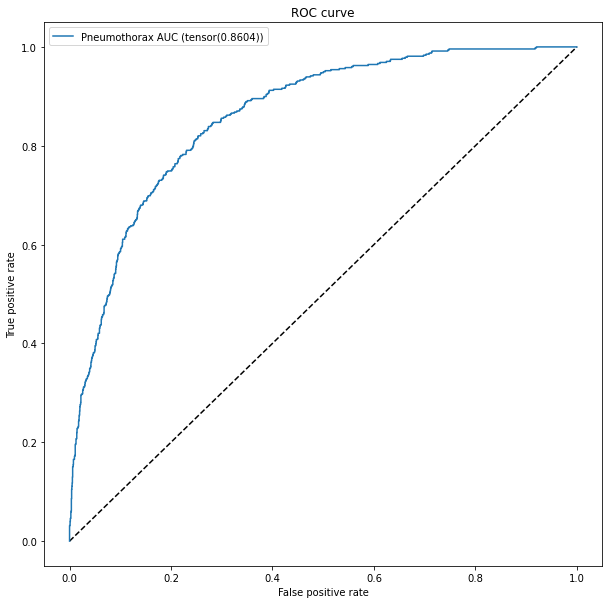

In [ ]:
auroc = AUROC(pos_label=1)
auc_roc = auroc(preds, labels)
roc_curve = torchmetrics.ROC(pos_label=1)
fpr_rf, tpr_rf, thresholds = roc_curve(preds,labels)
plt.figure(1, figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = "Pneumothorax AUC (" + str(auc_roc) + ")")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='upper left')

Вот что делает этот код:

- optimal_idx = np.argmax(tpr_rf - fpr_rf): Этот код находит индекс в массивах tpr_rf и fpr_rf, где разница между true positive rate (TPR) и false positive rate (FPR) максимальна. Это точка на ROC-кривой, которая наиболее близка к верхнему левому углу (idеальная точка классификации).

- optimal_threshold = thresholds[optimal_idx]: Используя найденный индекс optimal_idx, этот код извлекает соответствующее значение порога optimal_threshold из массива thresholds. Это значение порога, которое соответствует оптимальной точке на ROC-кривой.

- print(f'Optimal threshold: {optimal_threshold}'): Этот код выводит найденное оптимальное значение порога классификации.

Таким образом, этот код позволяет определить оптимальный порог классификации, основываясь на анализе ROC-кривой. Это может быть полезно при настройке классификатора, чтобы найти наилучший компромисс между чувствительностью и специфичностью модели.

In [ ]:
# TODO в качестве одного из пунктов домашки можно дать им либо полностью поиск оптимального порога, либо хотя бы оценку метрик с новым порогом
optimal_idx = np.argmax(tpr_rf - fpr_rf)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold}')

Optimal threshold: 0.7333755493164062


## Визуализация решений классификатора

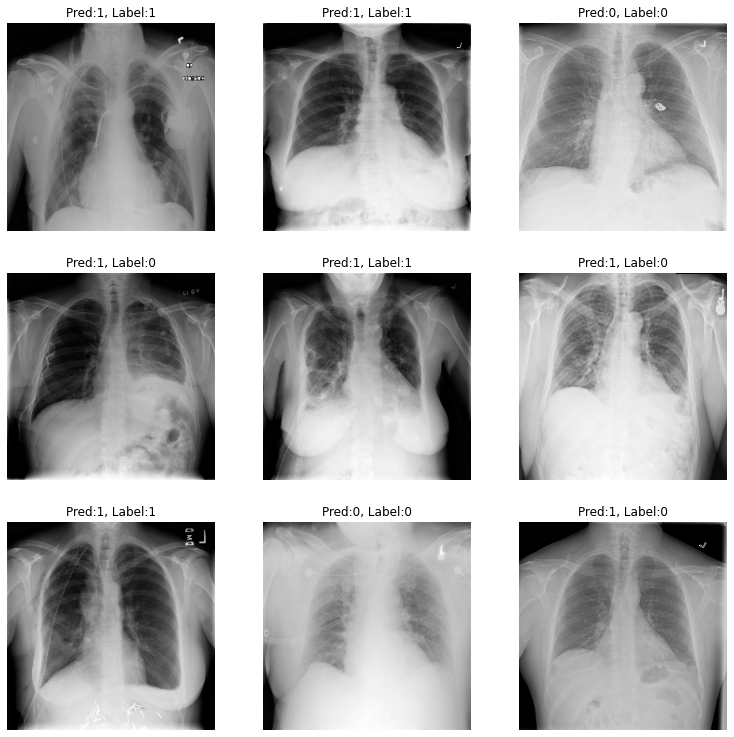

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(13, 13))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="gray")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


Мы используем метод Class Activation Maps (CAM) (https://arxiv.org/abs/1512.04150)

Идея CAM состоит в том, что мы умножаем вывод последнего сверточного слоя (BasicBlock 1 слоя 4) $A_k$ (имеющего k каналов) на параметры  $w$ следующего FC слоя, чтобы вычислить class activation map $M$:
$$ M = \sum_k w_kA_k$$

Для этого нам нужно получить доступ к выводу последнего сверточного слоя модели.<br />
Еще раз посмотрим на архитектуру:
Последний сверточный слой - conv2 в во втором BasicBlock в слое 4. Мы можем взять и вывод следующего слоя - BatchNorm2d.

In [ ]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Преобразуем сеть в генератор с помощью функции children() и получить доступ ко всем слоям.

In [ ]:
temp_model.children()

<generator object Module.children at 0x7f2e3960a1d0>

In [ ]:
# Преобразуем генератор в список с помощью функции list. Нам нужно извлечь все слои до слоя AdaptiveAvgPool2d.
list(temp_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
# Обратите внимание, мы получили все слои до (bn2): BatchNorm2d, но мы все еще не можем получить досуп к
# слоям внутри блока, поэтому если хотим "залезть" внутрь блока, нужно так же конвертировать его в список
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

Используя Sequential из pytorch, мы преобразуем список слоев обратно в Sequential model.

In [ ]:
# мы используем * перед list, чтобы конвертировать список в аргументы
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Итак, теперь мы имеем нашу pytorch-модель без последних двух слоев.

Мы добавляем дополнительный вывод в функцию forward нашей модели, чтобы вернуть карты признаков последнего конволюционного слоя ( 𝐴 ).

Так как мы извлекли global average pooling and flattening, мы должны вручную вернуть эти слои обратно. Наконец, мы используем FC слой для вычисления окончательного прогноза класса.

In [ ]:
class PneumothoraxModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.resnet18()
        # Выполняем те же манипуляции, что и раньше - меняем in и out
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        # Извлекаем feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, data):

        # Вычисляем feature map
        feature_map = self.feature_map(data)
        # Используем Adaptive Average Pooling как в исходной модели.
        # Эта функция сжимает 7x7x512 feature map в тензор 1x1x512
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        # Разворачиваем output в вектор 512
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        # Вычисляем предсказание
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map



In [ ]:
# Создаем экземпляр модели и загружаем чекпойнт
# strict=False - так как мы добавили feature map, а при обучении его не было и весов не существует,
# pythorch выдаст ошибку. False - загружает все веса, которые может сопоставить, и игнорирует остальные

model = PneumothoraxModel.load_from_checkpoint("logs/default/version_1/checkpoints/epoch=34-step=10499.ckpt", strict=False)
model.eval();

In [ ]:
def cam(model, img):

    # Вычислим pred и соответствующие фичи
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape

    # Наши фичи имеют размер 512х7х7, выполним reshape
    features = features.reshape((c, h*w))

    # Извлечем веса FC-слоя (без bias)
    weight_params = list(model.model.fc.parameters())[0]

    # Удалим информацию о градиентах
    weight = weight_params[0].detach()
    print(weight.shape)
    # Вычислим произведение между весами и фичами, как было представлено в формуле выше
    # Используем matmul, т.к. это перемножает каждый фильтр с весами,
    # затем вычилим сумму. В итоге получим вектор длиной 49 (7x7 элементов)
    cam = torch.matmul(weight, features)
    print(features.shape)

    # Нормализация и стандартизация САМ
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape CAM 512x7x7
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)

def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    # Resize activation map 7x7 к исходному размеру изображения (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]

    fig, axis = plt.subplots(1, 2)

    axis[0].imshow(img, cmap="gray")
    # Наложение исходного изображения с class activation map
    axis[1].imshow(img, cmap="gray")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumothorax pred: {(pred > 0.5).item()}")

In [ ]:
img = val_dataset[-2][0]  # Select a subject
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 49])


<Figure size 1080x1080 with 0 Axes>

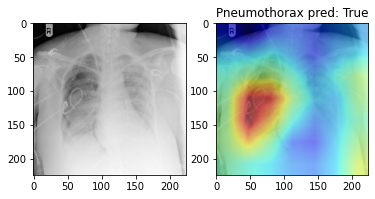

In [ ]:
visualize(img, activation_map, pred)  # Visualize CAM

### Задание.

1. Прочитать статью "An Improved VGG16 Model for Pneumonia Image Classification" by Zhi-Peng Jiang et al., 2021. https://www.mdpi.com/2076-3417/11/23/11185/htm

2. Реализовать модель диагностики пневмоторакса на основе IVGG13 (см. статью)

3. Выполнить тюнинг гиперпараметров модели и улучшить метрики accuracy, precision, recall по сравнению с исходной моделью, представленной в уроке.

4. Провести сравнительный анализ ROC-кривых полученных моделей. Выбрать оптимальный threshold.
